# Импорты

In [1]:
import pickle
import gc

import catboost as cb
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
#from malware_src.prepare_data import dataframe_to_pool
#from malware_src.visualization import plot_roc_curve
#from malware_src.model import load_model, apply_model_to_json

# Загрузка и разделение данных

In [2]:
dtypes = {
    'EngineVersion':                                     'category',
    'AppVersion':                                        'category',
    'AvSigVersion':                                      'category',
    'RtpStateBitfield':                                  'category',
    'DefaultBrowsersIdentifier':                         'category',
    'AVProductStatesIdentifier':                         'category',
    'AVProductsInstalled':                               'category',
    'AVProductsEnabled':                                 'category',
    'CountryIdentifier':                                 'category',
    'CityIdentifier':                                    'category',
    'OrganizationIdentifier':                            'category',
    'GeoNameIdentifier':                                 'category',
    'LocaleEnglishNameIdentifier':                       'category',
    'Platform':                                          'category',
    'Processor':                                         'category',
    'OsVer':                                             'category',
    'OsBuild':                                           'category',
    'OsSuite':                                           'category',
    'OsPlatformSubRelease':                              'category',
    'OsBuildLab':                                        'category',
    'SkuEdition':                                        'category',
    'IsProtected':                                       'category',
    'IeVerIdentifier':                                   'category',
    'SmartScreen':                                       'category',
    'Firewall':                                          'category',
    'Census_MDC2FormFactor':                             'category',
    'Census_OEMNameIdentifier':                          'category',
    'Census_OEMModelIdentifier':                         'category',
    'Census_ProcessorManufacturerIdentifier':            'category',
    'Census_ProcessorModelIdentifier':                   'category',
    'Census_ProcessorClass':                             'category',
    'Census_PrimaryDiskTypeName':                        'category',
    'Census_HasOpticalDiskDrive':                        'category',
    'Census_ChassisTypeName':                            'category',
    'Census_PowerPlatformRoleName':                      'category',
    'Census_InternalBatteryType':                        'category',
    'Census_OSVersion':                                  'category',
    'Census_OSArchitecture':                             'category',
    'Census_OSBranch':                                   'category',
    'Census_OSBuildNumber':                              'category',
    'Census_OSBuildRevision':                            'category',
    'Census_OSEdition':                                  'category',
    'Census_OSSkuName':                                  'category',
    'Census_OSInstallTypeName':                          'category',
    'Census_OSInstallLanguageIdentifier':                'category',
    'Census_OSUILocaleIdentifier':                       'category',
    'Census_OSWUAutoUpdateOptionsName':                  'category',
    'Census_GenuineStateName':                           'category',
    'Census_ActivationChannel':                          'category',
    'Census_FlightRing':                                 'category',
    'Census_FirmwareManufacturerIdentifier':             'category',
    'Census_FirmwareVersionIdentifier':                  'category',
    'Census_IsSecureBootEnabled':                        'category',
    'Census_IsTouchEnabled':                             'category',
    'Census_IsPenCapable':                               'category',
    'Census_IsAlwaysOnAlwaysConnectedCapable':           'category',
    'Wdft_IsGamer':                                      'category',
    'Wdft_RegionIdentifier':                             'category',
    'HasDetections':                                     'category',
    'Census_ProcessorCoreCount':                         'float16',
    'Census_PrimaryDiskTotalCapacity':                   'float64',
    'Census_SystemVolumeTotalCapacity':                  'float64',
    'Census_TotalPhysicalRAM':                           'float32',
    'Census_InternalPrimaryDiagonalDisplaySizeInInches': 'float32',
    'Census_InternalPrimaryDisplayResolutionHorizontal': 'float32',
    'Census_InternalPrimaryDisplayResolutionVertical':   'float32',
    'Census_InternalBatteryNumberOfCharges':             'float64'
}

In [19]:
categorical = [el for el in dtypes if dtypes[el] == 'category']
numerical = [el for el in dtypes if dtypes[el] != 'category']

In [52]:
seed = 2019
val_part = 0.2

In [58]:
%%time
data_path = '../data/filtered_train_data.csv'
data = pd.read_csv(data_path, dtype=dtypes)
train_data, val_data = train_test_split(data, test_size=val_part, random_state=seed)

TypeError: dataframe_to_pool() missing 3 required positional arguments: 'numeric_columns', 'categorical_columns', and 'target_column'

In [5]:
train_data.shape[0]

1000000

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 67 columns):
EngineVersion                                        1000000 non-null category
AppVersion                                           1000000 non-null category
AvSigVersion                                         1000000 non-null category
RtpStateBitfield                                     996334 non-null category
DefaultBrowsersIdentifier                            48303 non-null category
AVProductStatesIdentifier                            995907 non-null category
AVProductsInstalled                                  995907 non-null category
AVProductsEnabled                                    995907 non-null category
CountryIdentifier                                    1000000 non-null category
CityIdentifier                                       963487 non-null category
OrganizationIdentifier                               691064 non-null category
GeoNameIdentifier          

# Catboost

###  Обучение

In [38]:
def dataframe_to_pool(df,
               numeric_columns,
               categorical_columns,
               target_column,
               ):
    columns = numeric_columns + categorical_columns
    target = None
    if target_column in df.columns:
        target = df[target_column]
    df = df[columns].copy()
    for col in categorical_columns:
        df[col] = df[col].cat.add_categories(-1)
        df.loc[:, col] = df[col].fillna(-1)
    return cb.Pool(
            df,
            label=target,
            cat_features=categorical_columns,
        )


def json_to_pool(json_data,
            numeric_columns,
            categorical_columns,
            target_column
            ):
    df = pd.DataFrame(json_data, index=[0])
    return dataframe_to_pool(df,
                        numeric_columns,
                        categorical_columns,
                        target_column)

In [59]:
model = cb.CatBoostClassifier(iterations=100)
train_pool = dataframe_to_pool(train_data, numerical, categorical, 'HasDetections')
val_pool = dataframe_to_pool(val_data, numerical, categorical, 'HasDetections')

In [60]:
gc.collect()

20

In [61]:
%%time
#model.fit(train_pool, eval_set=val_pool, verbose=True)
model.fit(train_pool, eval_set=val_pool, verbose=True)

Learning rate set to 0.5
0:	learn: 0.6540201	test: 0.6540800	best: 0.6540800 (0)	total: 25.3s	remaining: 41m 47s
1:	learn: 0.6391347	test: 0.6391074	best: 0.6391074 (1)	total: 40.1s	remaining: 32m 46s
2:	learn: 0.6337850	test: 0.6336888	best: 0.6336888 (2)	total: 55s	remaining: 29m 37s
3:	learn: 0.6308730	test: 0.6307271	best: 0.6307271 (3)	total: 1m 3s	remaining: 25m 29s
4:	learn: 0.6291877	test: 0.6290695	best: 0.6290695 (4)	total: 1m 12s	remaining: 22m 59s
5:	learn: 0.6276804	test: 0.6273907	best: 0.6273907 (5)	total: 1m 21s	remaining: 21m 16s
6:	learn: 0.6262344	test: 0.6258957	best: 0.6258957 (6)	total: 1m 30s	remaining: 19m 58s
7:	learn: 0.6252441	test: 0.6249058	best: 0.6249058 (7)	total: 1m 39s	remaining: 19m 1s
8:	learn: 0.6245115	test: 0.6241608	best: 0.6241608 (8)	total: 1m 48s	remaining: 18m 21s
9:	learn: 0.6238581	test: 0.6235635	best: 0.6235635 (9)	total: 1m 59s	remaining: 17m 54s
10:	learn: 0.6227701	test: 0.6224830	best: 0.6224830 (10)	total: 2m 8s	remaining: 17m 23s
11

91:	learn: 0.6079059	test: 0.6077291	best: 0.6077291 (91)	total: 14m 16s	remaining: 1m 14s
92:	learn: 0.6078334	test: 0.6076693	best: 0.6076693 (92)	total: 14m 25s	remaining: 1m 5s
93:	learn: 0.6077785	test: 0.6076222	best: 0.6076222 (93)	total: 14m 33s	remaining: 55.8s
94:	learn: 0.6077253	test: 0.6075843	best: 0.6075843 (94)	total: 14m 42s	remaining: 46.5s
95:	learn: 0.6076806	test: 0.6075396	best: 0.6075396 (95)	total: 14m 51s	remaining: 37.1s
96:	learn: 0.6076225	test: 0.6074913	best: 0.6074913 (96)	total: 14m 59s	remaining: 27.8s
97:	learn: 0.6075828	test: 0.6074595	best: 0.6074595 (97)	total: 15m 8s	remaining: 18.5s
98:	learn: 0.6075180	test: 0.6074034	best: 0.6074034 (98)	total: 15m 17s	remaining: 9.27s
99:	learn: 0.6073868	test: 0.6072815	best: 0.6072815 (99)	total: 15m 26s	remaining: 0us

bestTest = 0.6072814833
bestIteration = 99

Wall time: 15min 59s


In [62]:
model_path = '../models/model.cb'
model.save_model(model_path)

In [63]:
feature_importance = model.get_feature_importance()
features = model.feature_names_

for feature_id in feature_importance.argsort()[::-1]:
    name = features[feature_id]
    importance = feature_importance[feature_id]
    print(f'{name:50}\t\t{importance}')

SmartScreen                                       		33.12626765699954
AVProductStatesIdentifier                         		9.683154514497478
AVProductsInstalled                               		8.033708984237073
EngineVersion                                     		5.6583380023606855
AppVersion                                        		4.622893722938757
Census_ProcessorModelIdentifier                   		3.7843538593606847
CountryIdentifier                                 		3.3487903638289795
AvSigVersion                                      		3.013425562106083
Wdft_IsGamer                                      		2.9370826006686612
Census_OSInstallTypeName                          		2.9285523791723618
Wdft_RegionIdentifier                             		1.6778611237575822
Census_ActivationChannel                          		1.6208203649414876
Census_OSBuildRevision                            		1.2779421228443004
Census_OEMNameIdentifier                          		1.2008582261496472
Census_OEMM

In [67]:
def plot_roc_curve(true,
                   pred,
                   name,
                   weights=None,
                   label='',
                   color='darkorange',
                   ax=None,
):
    if ax is None:
        ax = plt.gca()
    fpr, tpr, thr = roc_curve(true, pred, sample_weight=weights)
    lw = 2
    ax.plot(fpr,
            tpr,
            color=color,
            lw=lw,
            label=('ROC {} curve (area = {:0.3f})'
                   .format(label, roc_auc_score(true,
                                                pred,
                                                sample_weight=weights))))
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(name)
    ax.legend(loc="lower right")

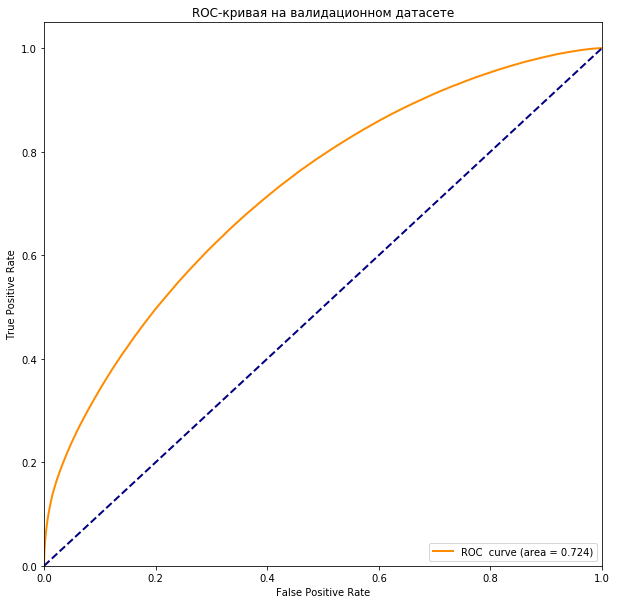

In [68]:
plt.figure(figsize=(10,10))
plot_roc_curve(true=val_pool.get_label(),
               pred=model.predict_proba(val_pool)[:,1],
               name='ROC-кривая на валидационном датасете')